In [144]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import normalize
%matplotlib notebook

# Helper Functions

In [97]:
def import_blight(location):
    ''' 
    Imports Blight_Violations.csv from location and converts it into a pandas dataframe.
    Location can be path or a device (XPS, and Workstation). Default locations are set for XPS, and Workstation.
    Returns a panda dataframe.   
    '''
    # Default locations for common devices
    if location == 'XPS':
        filepath = r"C:\Users\Adrian\Google Drive\Datasets\Blight_Violations.csv"
    elif location == 'Workstation':
        filepath = "C:\\Users\\aperez\\Google Drive\\Projects\\Machine Learning\\Blight_Violations.csv"
    # File path input
    else:
        filepath = location 
    # Converts CSV to pandas dataframe    
    blight_df = pd.read_csv(filepath, encoding = 'ISO-8859-1')    
    return blight_df

In [98]:
def pre_processing(blight_df):
    ''' 
    Takes blight panda dataframe and makes column names more reabable, sets ticket_id as index, 
    creates compliance (the prediction variable), and creates compliance_details (explains why a tickets was labeled as
    complantent or non-complantent).
    Returns a panda dataframe.
    '''
    #  Makes column names more reabable
    columns = blight_df.columns.values.tolist()
    lower_columns = [column.lower().replace(' ', '_').replace('-', '') for column in columns]
    blight_df.columns = lower_columns
    # Sets ticket_id as index
    blight_df.set_index('ticket_id', inplace=True)
    # Defines prediction variable compliance and helper variable compliance_detail
    # The values of these variables are NOT correct
    blight_df['compliance'] = 0
    blight_df['compliance_detail'] = np.NaN    
    return blight_df

In [1]:
def populate_compliance(blight_df):
    '''
    Populates compliance and compliance_details in blight_df with the correct values. Creates a copy of blight for correcting 
    altered variables. 
    Returns a panda dataframe.
    '''
    # creates copy of blight_df
    dummy_df = blight_df.copy()     
    # Tickets where compliance == None 
    # compliance is None by no fine, compliance_detail = 'Not Responsible/Pending Judgement' 
    null_dips = ['Not responsible by Dismissal', 'Not responsible by City Dismissal', 'PENDING JUDGMENT', 
                 'Not responsible by Determination','SET-ASIDE (PENDING JUDGMENT)']
    for null_dip in null_dips:
        blight_df.set_value(blight_df[blight_df['disposition'] == null_dip].index, 'compliance', np.NaN)
        blight_df.set_value(blight_df[blight_df['disposition'] == null_dip].index, 'compliance_detail', 'Not Responsible/Pending Judgement')
    # Tickets where compliance == 1
    # Compliant by no fine
    blight_df.set_value(blight_df[blight_df['disposition'] == 'Responsible (Fine Waived) by Determination'].index, 
                    'compliance', 1)
    blight_df.set_value(blight_df[blight_df['disposition'] == 'Responsible (Fine Waived) by Determination'].index, 
                    'compliance_detail', 'Compliant by no fine')
    # Compliant by Responsible (Fine Waived) by Admission
    blight_df.set_value(blight_df[blight_df['disposition'] == 'Responsible (Fine Waived) by Admission'].index, 
                    'compliance', 1)
    blight_df.set_value(blight_df[blight_df['disposition'] == 'Responsible (Fine Waived) by Admission'].index, 
                    'compliance_detail', 'Compliant by no fine')
    # Compliant by payment with PENDING hearing
    blight_df.set_value(blight_df[(blight_df['hearing_date'] == 'PENDING') & (blight_df['payment_amount'] > 0) & (blight_df['compliance_detail'].isnull())].index,
                'compliance', 1)
    blight_df.set_value(blight_df[(blight_df['hearing_date'] == 'PENDING') & (blight_df['payment_amount'] > 0) & (blight_df['compliance_detail'].isnull())].index,
                'compliance_detail', 'Compliant by payment with PENDING hearing')
    # Compliant by early payment
    blight_df.set_value(blight_df[(blight_df['payment_date'] < blight_df['hearing_date']) & (blight_df['compliance_detail'].isnull())].index,
                'compliance', 1)
    blight_df.set_value(blight_df[(blight_df['payment_date'] < blight_df['hearing_date']) & (blight_df['compliance_detail'].isnull())].index,
                'compliance_detail', 'Compliant by early payment')
    # Transforms dates in 'hearing_date' and 'payment_date' to panda date types
    blight_df.set_value(blight_df[blight_df['hearing_date'] == 'PENDING'].index, 'hearing_date', np.NaN)
    blight_df['hearing_date'] = pd.DatetimeIndex(blight_df['hearing_date'].str.extract('([0-9]{2}/[0-9]{2}/[0-9]{4})'))
    blight_df['payment_date'] = pd.DatetimeIndex(blight_df['payment_date'])
    # Compliant with payment on time
    blight_df.set_value(blight_df[(blight_df['payment_date'] == blight_df['hearing_date']) & 
                              (blight_df['compliance'] == 0)].index, 'compliance_detail', 'Compliant by payment on time')
    blight_df.set_value(blight_df[(blight_df['payment_date'] == blight_df['hearing_date']) & 
                              (blight_df['compliance'] == 0)].index, 'compliance', 1)
    # Compliant with payment on time
    blight_df.set_value(blight_df[(blight_df['payment_date'] < blight_df['hearing_date']) & (blight_df['compliance'] == 0)].index, 
                    'compliance_detail', 'Compliant with by payment')
    blight_df.set_value(blight_df[(blight_df['payment_date'] < blight_df['hearing_date']) & (blight_df['compliance'] == 0)].index, 
                    'compliance', 1)
    # Compliant by payment within 1 Month
    blight_df.set_value(blight_df[(((blight_df['payment_date'] - blight_df['hearing_date'])/np.timedelta64(1, 'M')) <= 1.0) & (blight_df['compliance'] == 0.0)].index,
                    'compliance_detail', 'Compliant by payment within 1 Month')
    blight_df.set_value(blight_df[(((blight_df['payment_date'] - blight_df['hearing_date'])/np.timedelta64(1, 'M')) <= 1.0) & (blight_df['compliance'] == 0.0)].index,
                    'compliance', 1)
    # Tickets where compliance == 0
    # Non-Compliant because they did not meet any of the requirements to be compliant. 
    blight_df.set_value(blight_df['compliance'] == 0.0, 'compliance_detail', 'Non-compliant by late payment or no payment')        
    # Adds updated compliance and compliance_detail to copied dataframe without variable changes
    dummy_df['compliance'] = blight_df['compliance']
    dummy_df['compliance_detail'] = blight_df['compliance_detail']  
    return dummy_df

In [100]:
def clean_data(blight_df):
    '''
    Removes instances with bad data (e.g. a string value in a interger feature).
    Returns a panda dataframe.
    '''
    # Removes string values from 'judgement_amount' and converts the feature to a float64
    blight_df.drop(blight_df[blight_df['judgment_amount'] == 'NO PAYMENT APPLIED'].index, inplace=True)
    blight_df['judgment_amount'] = blight_df['judgment_amount'].astype(float)
    return blight_df

In [101]:
def remove_leakage(blight_df):
    ''' 
    In blight_df removes variables to prevent data leakage and variables with mostly NaNs,
    Returns a panda dataframe
    '''
    blight_df = blight_df[['agency_name', 'inspector_name', 'violator_name','violation_street_number', 'violation_street_name', 
                       'mailing_address_str_number', 'mailing_address_str_name', 'city', 'state', 'zip_code', 'country', 
                       'ticket_issued_date', 'hearing_date', 'violation_code', 'violation_description', 'disposition', 
                       'fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'discount_amount', 
                       'judgment_amount', 'compliance']]   
    return blight_df    

In [102]:
def split_data(blight_df):
    ''' 
    Randomly splits blight_df into two sets: model_df (80%) and final_df (20%).
    FYI - model_df will be split again into train_df and test_df which will be used to develop and build model, and 
    final_df will be used to test the final model.
    Returns two pandas dataframes
    '''        
    model_df, final_df = train_test_split(blight_df, test_size=0.2)    
    return model_df, final_df

In [103]:
def split_model_data(model_df): 
    '''
    Splits model_df into two sets (training (80%) and testing (20%)) and then splits these sets into prediction and predictor
    variables (X and y). This results in four datasets: X_train, y_train, X_test, and y_test.
    Returns four pandas dataframes.
    '''
    X = model_df.iloc[:, blight_df.columns != 'compliance']
    y = model_df.iloc[:, blight_df.columns == 'compliance']
    X_train, X_test, y_train, y_test = train_test_split(X, y)    
    return X_train, X_test, y_train, y_test

In [104]:
def plot_auc(y_test, y_scores_lr):
    '''
    Plots the AUC curve for y_test and y_scores_lr.
    Returns nothing.
    '''   
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_scores_lr)
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    plt.figure()
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    plt.axes().set_aspect('equal')
    plt.show()

# Exploration and Data Cleanup 

In [136]:
blight_df = import_blight('XPS')
blight_df = pre_processing(blight_df)
blight_df = populate_compliance(blight_df)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (0,5,7,8,12,13,28,34,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: set_value is deprecated and will be removed in a f

## Exploring Prediction Variable: compliance 
Null = Not responsible, 0 = Responsible & non-compliant, 1 = Responsible & compliant

In [106]:
blight_df['compliance'].isnull().value_counts()

False    220908
True     118370
Name: compliance, dtype: int64

In [107]:
blight_df['compliance'].value_counts()

0.0    179616
1.0     41292
Name: compliance, dtype: int64

## Exploring Helper Variable: compliance_detail
More information on why each ticket was marked compliant or non-compliant, this variable will not be used in modeling

In [108]:
blight_df['compliance_detail'].value_counts()

Non-compliant by late payment or no payment    179616
Not Responsible/Pending Judgement              118370
Compliant by payment on time                    18172
Compliant by early payment                      10896
Compliant by payment within 1 Month             10240
Compliant by payment with PENDING hearing         994
Compliant by no fine                              977
Compliant with by payment                          13
Name: compliance_detail, dtype: int64

## Prevent Data leakage and Clean data

In [137]:
blight_df = remove_leakage(blight_df)
blight_df = clean_data(blight_df)

# Model Building

## Spliting Data

In [138]:
model_df, final_df = split_data(blight_df)
# Removes NaN from Variables
for col in model_df.columns:
    model_df = model_df[~model_df[col].isnull()]
X_train, X_test, y_train, y_test = split_model_data(model_df)

## Processing data for model building

### Label Encoding on categorical features

In [155]:
le = preprocessing.LabelEncoder()
cat_features = ['agency_name', 'inspector_name', 'violator_name', 'violation_street_name', 'mailing_address_str_name', 
             'city', 'state', 'zip_code', 'country', 'ticket_issued_date', 'hearing_date', 'violation_code', 
             'violation_description', 'disposition', 'mailing_address_str_number']
for col in cat_features:
    le.fit(X_train[col].astype(str))
    X_train_transform[col] = le.transform(X_train[col].astype(str))

### Normalization on numerical features

In [120]:
num_features = ['fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'discount_amount', 'judgment_amount']          
X_train_transform = min_max_scaler.fit_transform(X_train[['fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'discount_amount', 'judgment_amount']])
X_train_transform = pd.DataFrame(X_train_transform)
X_train_transform.columns = ['fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'discount_amount', 'judgment_amount']

### Random Forest Classifier

In [157]:
forest = ExtraTreesClassifier(n_estimators=100, random_state=0, n_jobs=-1, max_features='auto', max_depth=5)
forest.fit(X_train_transform, np.ravel(y_train))

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=5, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [158]:
# Print the feature ranking
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
print('Features with Importance Greather than 0.05')
for f in range(X_train_transform.shape[1]):
    if importances[indices[f]] >= 0.05:
        print("%d. %s (%f)" % (f + 1, X_train_transform.columns[indices[f]], importances[indices[f]]))

Features with Importance Greather than 0.05
1. disposition (0.607573)
2. late_fee (0.098204)
3. discount_amount (0.062734)
4. violation_code (0.058717)


<IPython.core.display.Javascript object>


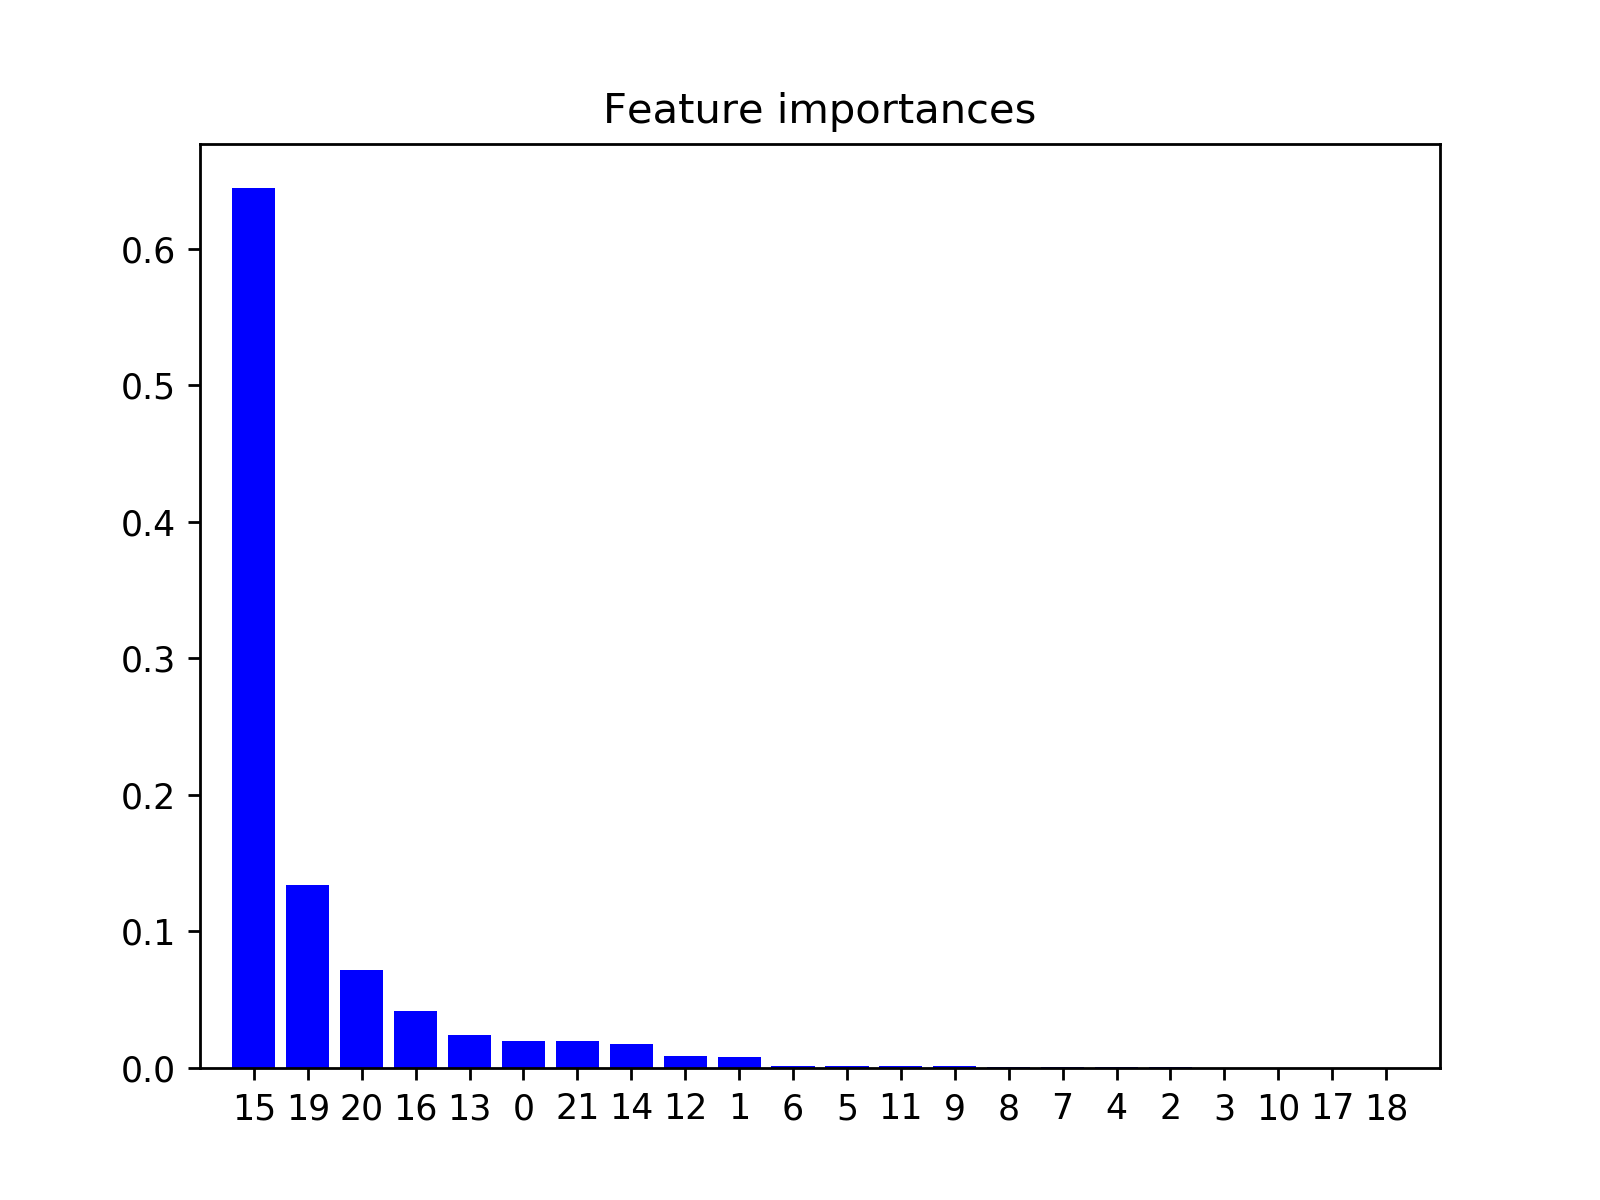

In [128]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="b", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [159]:
# Tranform data based on Random Forest
model = SelectFromModel(forest, prefit=True, threshold = 0.05)
X_train_transform = model.transform(X_train_transform)

## Model Building

### Fit Neural Network

In [160]:
nnclf = MLPClassifier(hidden_layer_sizes = [18], activation='relu', solver='adam', random_state = 0, alpha = 5)
nnclf.fit(X_train_transform, np.ravel(y_train))

MLPClassifier(activation='relu', alpha=5, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[18], learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [167]:
for col in trans_col:
    #le.fit(X_test[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))

ValueError: y contains new labels: ['Buildings, Safety Engineering & Env Department'
 'Department of Public Works' 'Detroit Police Department'
 'Health Department']

In [171]:
blight_df['agency_name'].value_counts()

Buildings, Safety Engineering & Env Department    189529
Department of Public Works                        126252
Detroit Police Department                          14591
Health Department                                   8903
Neighborhood City Halls                                2
Name: agency_name, dtype: int64

In [132]:
X_test_transform = model.transform(X_test)

In [134]:
X_test_transform = min_max_scaler.transform(X_test)

In [135]:
y_probs = nnclf.predict_proba(X_test_transform)

ValueError: shapes (43338,22) and (3,18) not aligned: 22 (dim 1) != 3 (dim 0)

<IPython.core.display.Javascript object>


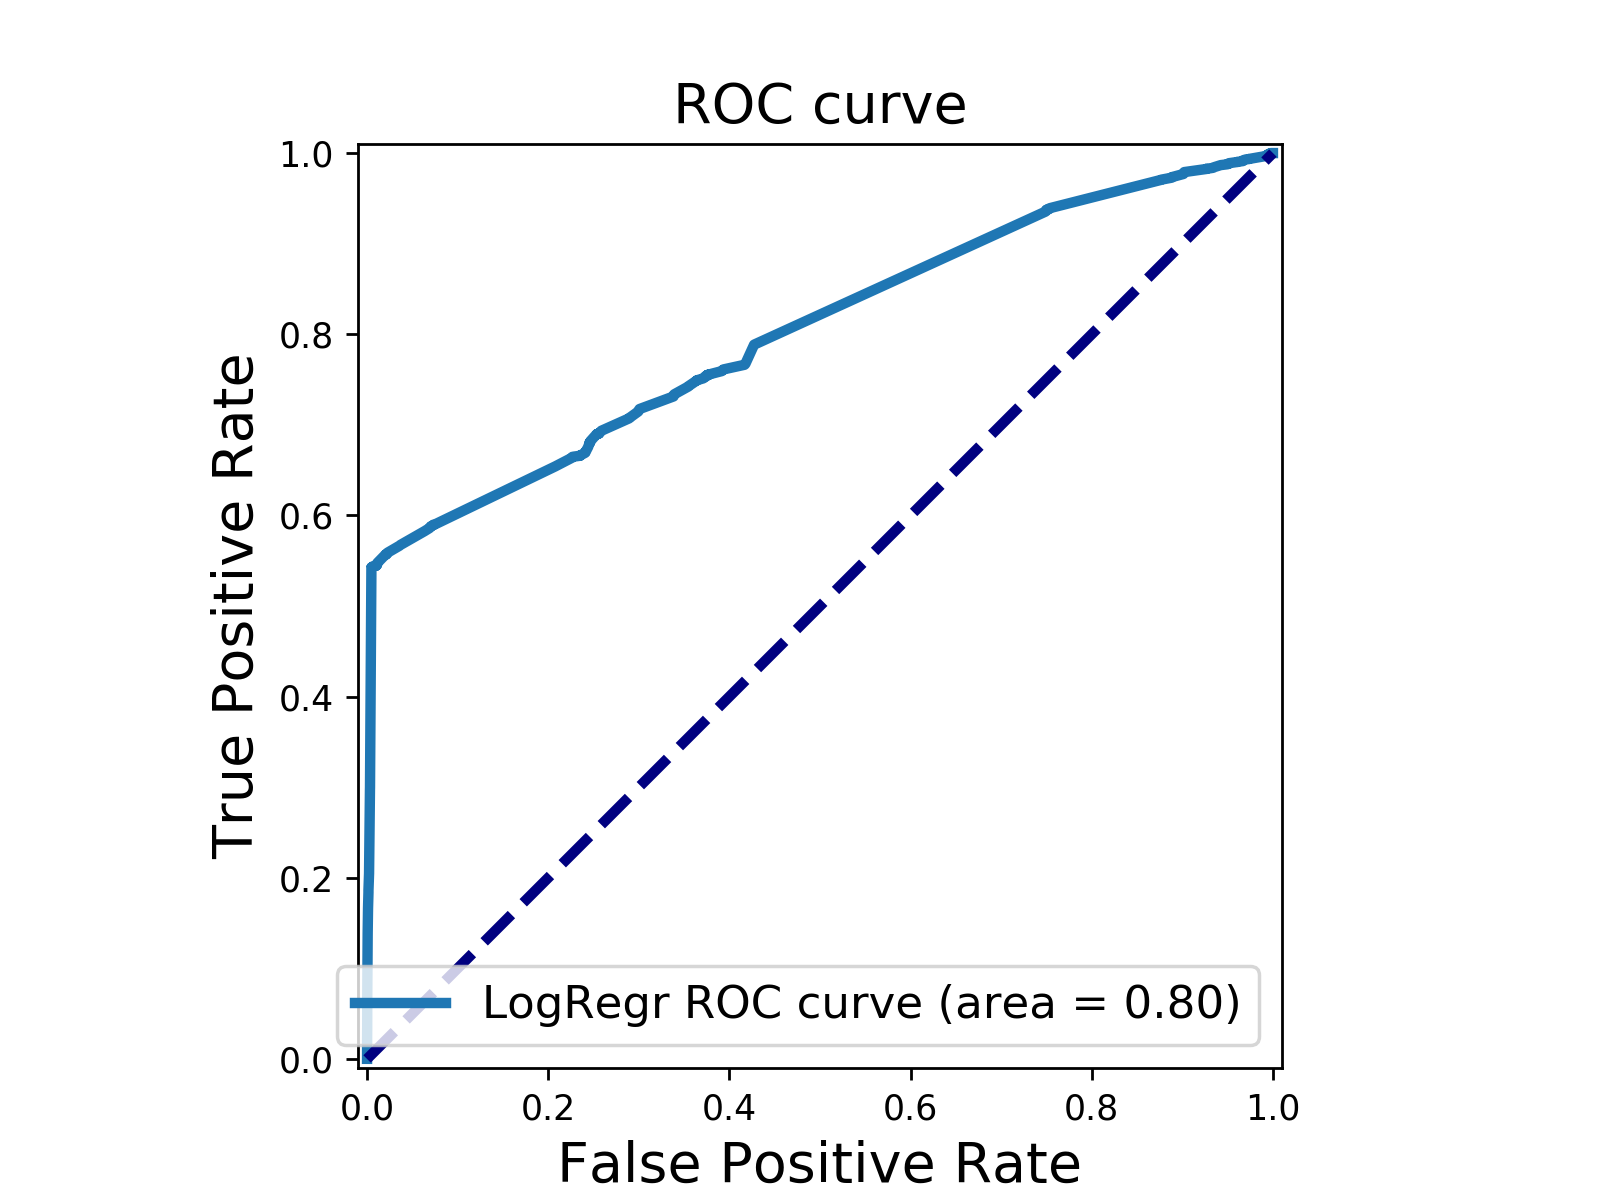

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [86]:
plot_auc(y_test, y_probs[:,1])